In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
from transformers import (BertModel, 
                          BertTokenizer)

from tqdm.notebook import tqdm

Read the data

In [3]:
data = pd.read_csv("dataset/data.csv", sep = ";")
data.head()

,text,label
0,fucks sake go away stupid anon — ^ https://t....,abusive
1,Damn dean just put Corbin to sleep. That Match...,abusive
2,@TheRealCamerota THAT BEER BUYING FREAKING IDI...,abusive
3,what idiot called them antacids and not afterb...,abusive
4,RT @gogglepossum: Don't you hate people that p...,abusive


Preprocess the dataset

In [4]:
def preprocess(A, labels):
    B = []
    labels_new = []
    for i in range(len(A)):

        text = A[i]
        # remove old style retweet text "RT"
        text = re.sub(r'^RT[\s]+', '', text)

        # remove hyperlinks
        text= re.sub(r'https?:\/\/.*[\r\n]*', '', text)

        # remove hashtags
        # only removing the hash # sign from the word
        text = re.sub(r'#', '', text)

        # remove tagging @
        text = re.sub(r"(?:\@|https?\://)\S+", "", text)

        # remove new line \n
        text = re.sub("\n", "", text)
        
        # remove numbers
        text = text.replace("[0-9]", " ")
    
        # to lower case
        text = text.lower()

        # remove zero length tweets
        if(len(text) == 0 ):
            continue

        B.append(text)
        labels_new.append(labels[i])
    return B, labels_new

In [5]:
texts, labels = preprocess(data["text"], data["label"])
len(texts)

57581

In [6]:
bert_model = BertModel.from_pretrained("bert-base-cased", output_hidden_states = True)

In [7]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [8]:
tokenized_labels = dict()
max_length = 0
for label in list(set(labels)):
    tokenized_labels[label] = bert_tokenizer.tokenize(f" - This is {label}")
    if len(tokenized_labels[label]) > max_length:
        max_length = len(tokenized_labels[label])

    
print(max_length)
tokenized_labels
    


8


{'racism': ['-', 'This', 'is', 'racism'],
 'hateful': ['-', 'This', 'is', 'hate', '##ful'],
 'sexism': ['-', 'This', 'is', 'sex', '##ism'],
 'benevolent': ['-', 'This', 'is', 'ben', '##evo', '##lent'],
 'abusive': ['-', 'This', 'is', 'abusive'],
 'cyberbulling': ['-', 'This', 'is', 'c', '##y', '##ber', '##bull', '##ing'],
 'toxic': ['-', 'This', 'is', 'toxic'],
 'obscene': ['-', 'This', 'is', 'o', '##bs', '##cene'],
 'identity': ['-', 'This', 'is', 'identity'],
 'profane': ['-', 'This', 'is', 'pro', '##fan', '##e'],
 'threat': ['-', 'This', 'is', 'threat'],
 'insult': ['-', 'This', 'is', 'insult'],
 'offensive': ['-', 'This', 'is', 'offensive'],
 'spam': ['-', 'This', 'is', 'spa', '##m'],
 'hate': ['-', 'This', 'is', 'hate']}

In [9]:
tokenized_labels_lengths = dict()
for label in list(set(labels)):
    tokenized_labels_lengths[label] = len(tokenized_labels[label][3:])
    
tokenized_labels_lengths

{'racism': 1,
 'hateful': 2,
 'sexism': 2,
 'benevolent': 3,
 'abusive': 1,
 'cyberbulling': 5,
 'toxic': 1,
 'obscene': 3,
 'identity': 1,
 'profane': 3,
 'threat': 1,
 'insult': 1,
 'offensive': 1,
 'spam': 2,
 'hate': 1}

In [10]:
texts_new = []
for i, text in enumerate(texts):
    texts_new.append(f"{text} - This is {labels[i]}")

In [11]:
texts_new[0:10]

['fucks sake go away stupid anon — ^   - This is abusive',
 'damn dean just put corbin to sleep. that match also showed why it was on pre show. boring as fuck - This is abusive',
 ' that beer buying freaking idiot thinks trump leaked it to nail rice? are you kidding? and sacrifice flynn. mud is appropo - This is abusive',
 'what idiot called them antacids and not afterburners - This is abusive',
 " don't you hate people that put salt on their bag of dicks before even trying them? - This is abusive",
 'you worried about somebody bein ugly... bitch you ugly... - This is abusive',
 'holy crap!! the biggest assclown of a mayor on  pulling race card!! get his ass outta office!!! draintheswamp - This is abusive',
 ' i just want to cry so fucking bad look at them  - This is abusive',
 'yooooo vans got these sick ass velvet oxblood slip onnnnssssss 💦💦💦💦👅👅👅👅 - This is abusive',
 ' disgusting. insulting. parks are not a charity. give them a fucking budget, asshole.  theresistance… - This is abus

How many sequences are too long to add the label sentence?

In [12]:
pad_token=0
pad_token_segment_id=0
max_length=512

def convert_to_input(reviews):
  input_ids,attention_masks,token_type_ids, nums=[],[],[],[]
  
  for x in tqdm(reviews,position=0, leave=True):
    inputs = bert_tokenizer.encode_plus(x,add_special_tokens=True, max_length=max_length, return_overflowing_tokens=True)
    
    i, t, num = inputs["input_ids"], inputs["token_type_ids"], inputs["num_truncated_tokens"]
    m = [1] * len(i)
            
    padding_length = max_length - len(i)

    i = i + ([pad_token] * padding_length)
    m = m + ([0] * padding_length)
    t = t + ([pad_token_segment_id] * padding_length)
    
    input_ids.append(i)
    attention_masks.append(m)
    token_type_ids.append(t)
    nums.append(num)
  
  return [np.asarray(input_ids), 
            np.asarray(attention_masks), 
            np.asarray(token_type_ids),
            np.asarray(nums)]

In [13]:
test = convert_to_input(texts)

  0%|          | 0/57581 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Remove truncated sentences as we lose the labes

In [14]:
idx = np.array(test[3]) <= 0

In [15]:
inputs = np.array(test[0:3])
inputs = inputs[:, idx, :]
inputs.shape

(3, 56708, 512)

In [16]:
labels = np.array(labels)
labels = labels[idx]
len(labels)

56708

In [17]:
last = sum(inputs[1,40000,:]) - 1
first = last - tokenized_labels_lengths[labels[40000]]

inputs[0, 40000, first:last]

array([ 3687, 16618,  1122])

In [18]:
#token_embeddings = torch.stack(hidden_states, dim=0)
import tensorflow as tf
import torch

embeddings = []

bert_model = bert_model.to("cuda")
for j in tqdm(range(inputs.shape[1])):
#with torch.no_grad():
    inputs1 = torch.tensor(inputs[:,j,:])
    inputs1 = inputs1.to("cuda")

    output = bert_model(inputs1)
    hidden_states = output.hidden_states

    token_embeddings = torch.stack(hidden_states, dim= 0)[:, 0, :, :]
    token_embeddings = token_embeddings.cpu()

    tokens = []
    
    last = sum(inputs[1,j,:]) - 1
    first = last - tokenized_labels_lengths[labels[j]]
    
    # get embeddings by summing last 4 layers
    for i in range(token_embeddings.shape[1]):
        tokens.append(np.sum(token_embeddings[-4:, i, :].detach().numpy(), axis = 0))
        
    tokens = np.array(tokens)
    tokens = tokens[first:last, :]
    tokens = np.mean(tokens, axis = 0)
    embeddings.append(tokens)

  0%|          | 0/56708 [00:00<?, ?it/s]

C:\Users\matij\anaconda3\envs\nlp\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\matij\anaconda3\envs\nlp\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [21]:
test = np.array(embeddings)
test.shape

(56708, 768)

In [22]:
np.savez_compressed("embeddings", embeddings=test)

Import the model

In [ ]:
#from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('bert-base-nli-mean-tokens', 'cuda')

#model = SentenceTransformer('distilbert-base-nli-mean-tokens', "cuda")

#model.max_seq_length = 512

In [23]:
#ids = np.random.choice(list(range(len(texts))), size = 57581)
#ids = np.arange(0, len(labels))
#ids = np.sort(ids)
#l = np.array(labels)[ids]
#t = np.array(texts)[ids]
#ids = np.argsort(l)
#l = l[ids]
#t = t[ids]
#l
idx = np.argsort(labels)
labels = labels[idx]
sentence_embeddings = test[idx, :]

In [ ]:
#texts

In [25]:
#sentences = ['This framework generates embeddings for each input sentence',
#    'Sentences are passed as a list of string.', 
#    'The quick brown fox jumps over the lazy dog.']
#sentence_embeddings = model.encode(t, show_progress_bar = True)
#
#print("Sentence embeddings:")
#print(sentence_embeddings)
print(sentence_embeddings)

[[-4.593318   -5.7181816  -0.5780396  ... -5.6984506   0.8760278
   4.9951053 ]
 [ 0.5288634  -1.5946627   0.5654395  ... -4.2381983  -1.6394398
  -0.69327927]
 [ 0.08158546 -3.638883    1.0736246  ... -5.057759    5.2808337
   3.50873   ]
 ...
 [-4.7490363  -4.1965904   1.0788589  ... -3.1065626   3.1893675
  -0.42115948]
 [ 0.595692   -1.5792352   0.46107382 ... -1.960351   -1.0385844
   5.9837785 ]
 [-2.007664   -2.595       2.1171632  ... -3.8738675   5.095543
   2.5293028 ]]


In [30]:
idx = np.isnan(sentence_embeddings).any(axis = 1)
sentence_embeddings = sentence_embeddings[~idx]
labels = labels[~idx]

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# calculate distance between every embedding pair
sim_mat = cosine_similarity(sentence_embeddings, sentence_embeddings)
#df['sim_score'] = sim_mat[sentence_id]
print(sim_mat.shape)

(56581, 56581)


In [ ]:
#fig, ax = plt.subplots(figsize=(20,20))
#cax = ax.matshow(sim_mat, interpolation='nearest',cmap=plt.get_cmap("PiYG", 7))
#plt.show()

In [ ]:
test = np.array(labels)[ids]
test[380]

In [32]:
l = labels

In [33]:
score = {}
for i in range(len(l)):
    x = score.get(l[i])
    if x is None:
        x = []
    x.append(sim_mat[100,i])
    score[l[i]] = x

In [34]:
for k,v in score.items():
    print(f"{k}:{sum(v)/len(v)}")

abusive:0.6111448857068846
benevolent:0.6230624404892344
cyberbulling:0.5067258853980197
hate:0.5342457341148129
hateful:0.6113843444726287
identity:0.6042040066293495
insult:0.612733682946361
obscene:0.6025878094135811
offensive:0.5403833301594624
profane:0.5752135841619401
racism:0.6156023163880621
sexism:0.6001643895883585
spam:0.6058953251968702
threat:0.6292168477574132
toxic:0.6069627558413572


In [35]:
labs, occ = np.unique(l, return_counts = True)
occ

array([ 4219,  2339,   246,  1264,  1748,  1367,  7704,  8243,   520,
         756,   140,  3533,  7610,   466, 16426], dtype=int64)

In [36]:
print(l)
print(labs)

['abusive' 'abusive' 'abusive' ... 'toxic' 'toxic' 'toxic']
['abusive' 'benevolent' 'cyberbulling' 'hate' 'hateful' 'identity'
 'insult' 'obscene' 'offensive' 'profane' 'racism' 'sexism' 'spam'
 'threat' 'toxic']


In [37]:
indices = np.cumsum(occ)
indices = np.insert(indices, 0, 0)
indices

array([    0,  4219,  6558,  6804,  8068,  9816, 11183, 18887, 27130,
       27650, 28406, 28546, 32079, 39689, 40155, 56581], dtype=int64)

In [38]:
new_m = np.zeros((len(occ), len(occ)))
for i in range(len(indices)-1):
    for j in range(len(indices)-1):
        x = indices[i]
        y = indices[j]
        x1 = indices[i+1]
        y1 = indices[j+1]
        
        #print(f"{x},{y},{x1},{y1}")
        new_m[i,j] = np.mean(sim_mat[int(x):int(x1), int(y):int(y1)])

In [39]:
df = pd.DataFrame(new_m, columns = labs, index = labs)
df

,abusive,benevolent,cyberbulling,hate,hateful,identity,insult,obscene,offensive,profane,racism,sexism,spam,threat,toxic
abusive,0.553273,0.585652,0.484954,0.517851,0.568438,0.535494,0.541423,0.551191,0.519699,0.555197,0.565533,0.564797,0.563643,0.541102,0.536920
benevolent,0.585653,0.703824,0.609013,0.568021,0.643993,0.580309,0.585881,0.627860,0.567023,0.630388,0.612130,0.636468,0.633038,0.590648,0.582779
cyberbulling,0.484953,0.609013,0.632210,0.486140,0.555236,0.513246,0.518506,0.560626,0.482850,0.535326,0.518707,0.544915,0.535379,0.527959,0.519149
hate,0.517851,0.568021,0.486140,0.528531,0.542731,0.510317,0.514081,0.531084,0.529418,0.558966,0.542165,0.543816,0.540961,0.511250,0.509818
hateful,0.568438,0.643994,0.555236,0.542731,0.612147,0.557483,0.563059,0.594908,0.542696,0.594870,0.589689,0.606285,0.604426,0.565092,0.559383
identity,0.535494,0.580309,0.513246,0.510317,0.557483,0.549294,0.556676,0.551795,0.510621,0.533629,0.564499,0.556286,0.551090,0.559922,0.554365
insult,0.541423,0.585881,0.518506,0.514081,0.563059,0.556676,0.565051,0.557364,0.514316,0.536154,0.571480,0.561913,0.556464,0.568590,0.562884
obscene,0.551190,0.627861,0.560626,0.531084,0.594908,0.551795,0.557367,0.595289,0.531403,0.589872,0.572842,0.592479,0.590277,0.558649,0.553973
offensive,0.519700,0.567022,0.482850,0.529418,0.542696,0.510621,0.514316,0.531403,0.534246,0.561861,0.542669,0.542909,0.540945,0.511380,0.509767
profane,0.555197,0.630388,0.535326,0.558966,0.594870,0.533629,0.536154,0.589873,0.561860,0.646922,0.570930,0.596502,0.595026,0.530630,0.530167


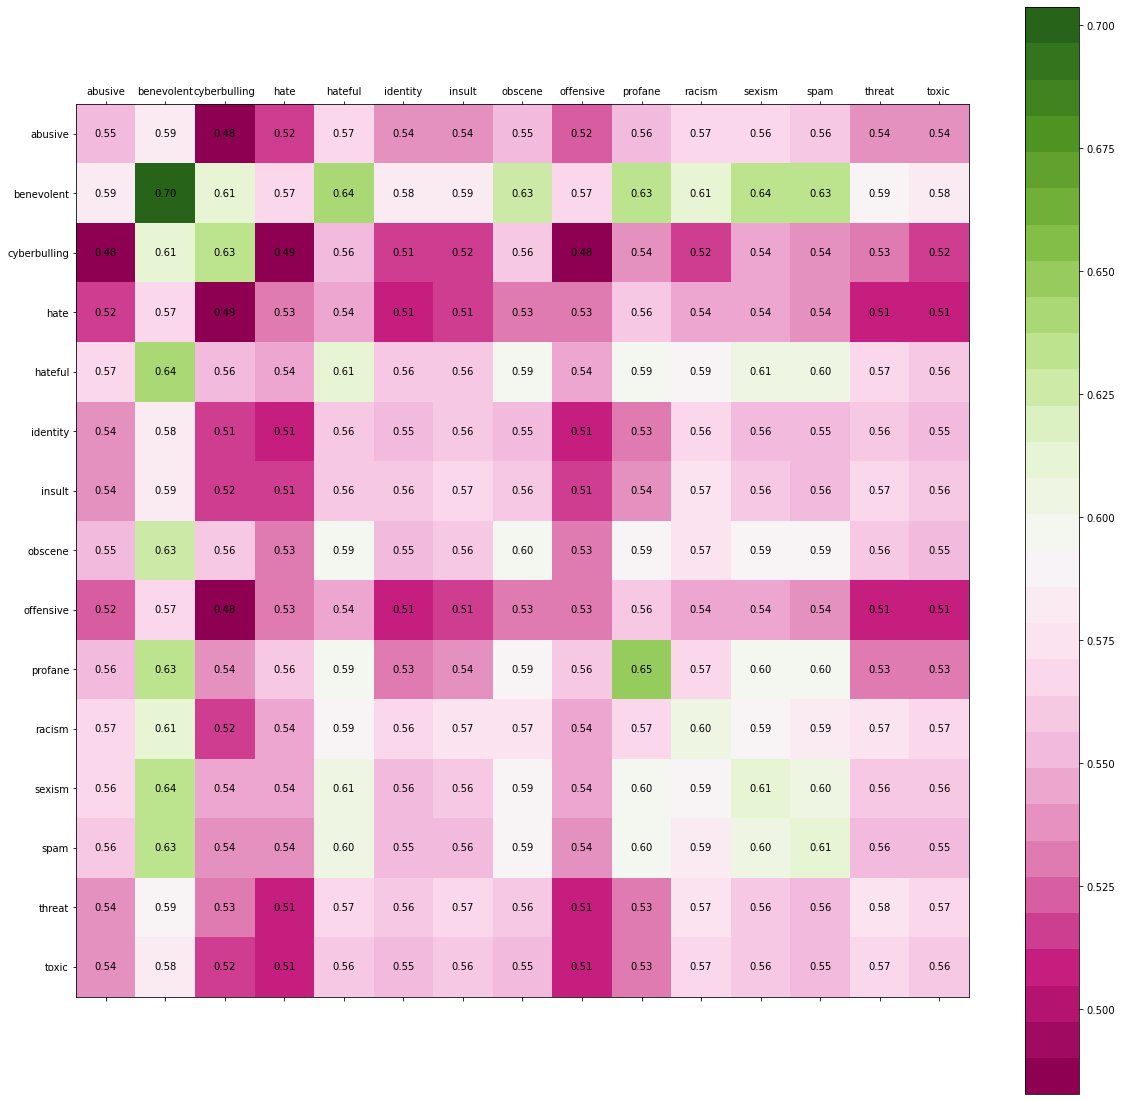

In [40]:
fig, ax = plt.subplots(figsize=(20,20))
cax = ax.matshow(df, interpolation='nearest',cmap=plt.get_cmap("PiYG", 30))

for i in range(new_m.shape[0]):
    for j in range(new_m.shape[0]):
        c = new_m[j,i]
        ax.text(i, j, f"{c:.2f}", va='center', ha='center')

fig.colorbar(cax)

ax.set_xticks(np.arange(len(labs)))
ax.set_yticks(np.arange(len(labs)))
ax.set_xticklabels(labs.tolist())
ax.set_yticklabels(labs.tolist())
plt.show()

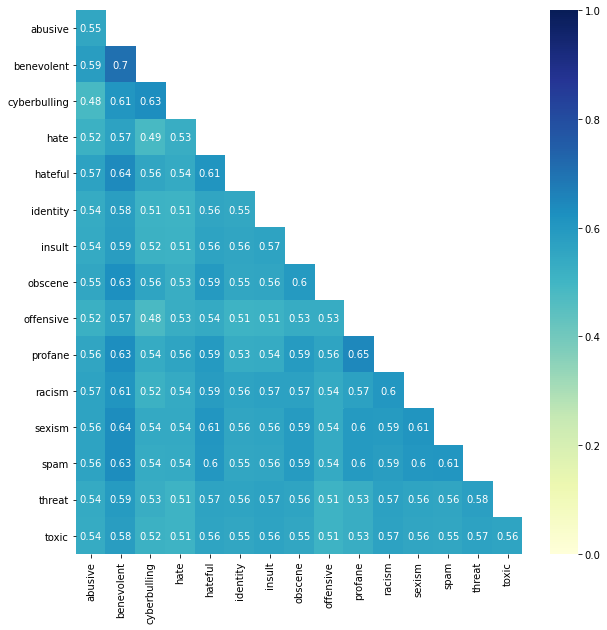

In [41]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
mask = np.triu(np.ones_like(new_m), k = 1)
sns.heatmap(df, cmap="YlGnBu", annot=True, mask=mask, ax = ax, vmin=0, vmax=1)
plt.show()

In [ ]:
import torch
print(torch.cuda.is_available())

In [ ]:
torch.zeros(1).cuda()

In [ ]:
#!pip uninstall -y torch

In [42]:
indices

array([    0,  4219,  6558,  6804,  8068,  9816, 11183, 18887, 27130,
       27650, 28406, 28546, 32079, 39689, 40155, 56581], dtype=int64)

In [45]:
avgs = []
for i in range(len(indices) - 1):
    avgs.append(np.mean(sentence_embeddings[indices[i]:indices[i+1]], axis = 0))

768

In [46]:
df1 = pd.DataFrame(cosine_similarity(avgs, avgs), columns = labs, index = labs)
df1

,abusive,benevolent,cyberbulling,hate,hateful,identity,insult,obscene,offensive,profane,racism,sexism,spam,threat,toxic
abusive,1.000000,0.938599,0.818954,0.957781,0.976827,0.971301,0.968291,0.961377,0.956116,0.928260,0.979165,0.970900,0.971444,0.957795,0.963408
benevolent,0.938599,1.000000,0.912015,0.931234,0.981058,0.933156,0.928934,0.969382,0.924678,0.933367,0.939350,0.969473,0.966988,0.926690,0.927067
cyberbulling,0.818954,0.912015,1.000000,0.840086,0.891525,0.870041,0.866623,0.910215,0.829834,0.834021,0.838238,0.874227,0.861959,0.872846,0.870638
hate,0.957781,0.931234,0.840086,1.000000,0.954153,0.947211,0.940882,0.947062,0.996321,0.955683,0.960422,0.956289,0.953615,0.926049,0.936182
hateful,0.976827,0.981058,0.891525,0.954153,1.000000,0.961437,0.957486,0.985596,0.949039,0.944881,0.970477,0.990603,0.990286,0.950962,0.954387
identity,0.971301,0.933156,0.870041,0.947211,0.961437,1.000000,0.999218,0.964675,0.942733,0.894692,0.980345,0.959267,0.953242,0.994417,0.998370
insult,0.968291,0.928934,0.866623,0.940882,0.957486,0.999218,1.000000,0.960705,0.936300,0.886362,0.978533,0.955417,0.949117,0.995580,0.999465
obscene,0.961377,0.969382,0.910215,0.947062,0.985596,0.964675,0.960705,1.000000,0.942750,0.951052,0.956060,0.981862,0.981138,0.952780,0.957852
offensive,0.956116,0.924678,0.829834,0.996321,0.949039,0.942733,0.936300,0.942750,1.000000,0.955542,0.956251,0.949663,0.948557,0.921378,0.931103
profane,0.928260,0.933367,0.834021,0.955683,0.944881,0.894692,0.886362,0.951052,0.955542,1.000000,0.914071,0.948126,0.947879,0.868110,0.879310


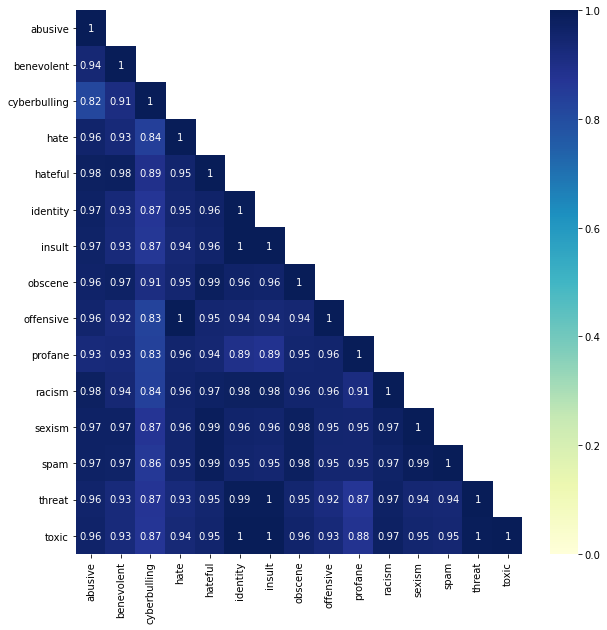

In [47]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
mask = np.triu(np.ones_like(new_m), k = 1)
sns.heatmap(df1, cmap="YlGnBu", annot=True, mask=mask, ax = ax, vmin=0, vmax=1)
plt.show()